In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import Bio
import Bio.SeqIO
import re
import os
import pickle

from timeit import default_timer as timer
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from timeit import default_timer as timer


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]='2,3'

In [4]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = 'cpu'
DEVICE

device(type='cuda')

In [6]:
os.sys.path.append('/home/yisupeng/workspace/CAFA_CODE/python/')

In [7]:
from ontology import *

In [8]:
from gene_ontology import *

## Dataset

### Target vocab

In [9]:
ont_pickle = 'states/ont.pickle'
if os.path.exists(ont_pickle):
    ont = pickle.load(open(ont_pickle, 'rb'))
else:
    ont = Ontology(parse_ont('data/go-basic.obo'))
    pickle.dump(ont, open(ont_pickle, 'wb'))

In [10]:
ont.roots

{'GO:0003674', 'GO:0005575', 'GO:0008150'}

In [11]:
class OntVocab:
    def __init__(self, ont):
        self.terms = []
        term_ind = {}
        for i, k in enumerate(ont.topological_order()):
            v = ont[k]
            if v.depth > 3:
                break
            term_ind[k] = i
            self.terms.append(k)
        self.term_ind = term_ind

    def __getitem__(self, i):
        return self.terms[i]

    def __call__(self, token):
        return self.term_ind[token]


target_vocab = OntVocab(ont)
list(target_vocab)

['GO:0008150',
 'GO:0003674',
 'GO:0005575',
 'GO:0032502',
 'GO:0002376',
 'GO:0050896',
 'GO:0065007',
 'GO:0044419',
 'GO:0048511',
 'GO:0042592',
 'GO:0040011',
 'GO:0008152',
 'GO:0051179',
 'GO:0043473',
 'GO:0032501',
 'GO:0009987',
 'GO:0044848',
 'GO:0051703',
 'GO:0016032',
 'GO:0040007',
 'GO:0000003',
 'GO:0140691',
 'GO:0098772',
 'GO:0140489',
 'GO:0140110',
 'GO:0005198',
 'GO:0016209',
 'GO:0038024',
 'GO:0045735',
 'GO:0140522',
 'GO:0140912',
 'GO:0140223',
 'GO:0060089',
 'GO:0005215',
 'GO:0031386',
 'GO:0140104',
 'GO:0060090',
 'GO:0090729',
 'GO:0045182',
 'GO:0140776',
 'GO:0140911',
 'GO:0140657',
 'GO:0044183',
 'GO:0003774',
 'GO:0140299',
 'GO:0140777',
 'GO:0140313',
 'GO:0003824',
 'GO:0005488',
 'GO:0032991',
 'GO:0044423',
 'GO:0110165',
 'GO:0021700',
 'GO:0097737',
 'GO:0043934',
 'GO:0098727',
 'GO:0048856',
 'GO:0043696',
 'GO:0022611',
 'GO:0031128',
 'GO:0002252',
 'GO:0019882',
 'GO:0009605',
 'GO:0051606',
 'GO:0014823',
 'GO:0014854',
 'GO:00096

In [12]:
len(list(target_vocab))

554

### Source vocab

In [13]:
hyper_aa_regex = re.compile('[BXZJUO]')

In [14]:
MAX_LEN = 2000

In [15]:
import torch

In [16]:
modelname = 'seq_ann_depth3_protbert_llm2vec'

In [17]:
states_dir = f'states/{modelname}/'
if not os.path.exists(states_dir):
    os.makedirs(states_dir)

In [18]:
seq_file = "data/uniprot_sprot.fasta"
# seq_file = "data/debugging_sequence.fasta"

def load_seqdb():
    seqdb_pickle = f'{states_dir}/seqdb.pickle'
    if os.path.exists(seqdb_pickle):
        seqdb = pickle.load(open(seqdb_pickle, 'rb'))
    else:
        seqdb = {}
        irregs = 0
        for record in Bio.SeqIO.parse(seq_file, "fasta"):
            if '|' in record.id:
                _, acc, geneid = record.id.split('|')
            else:
                acc = record.id
            if hyper_aa_regex.findall(str(record.seq)):
                irregs += 1
                continue
            # if len(record.seq) > MAX_LEN:
            #     irregs += 1
            #     continue
            seqdb[acc] = record
        print('irregs', irregs)
        pickle.dump(seqdb, open(seqdb_pickle, 'wb'))
        seqdb = pickle.load(open(seqdb_pickle, 'rb'))
    return seqdb


### build dataset

In [19]:
# load data
# datatab = pd.read_csv('data/sample_annot.csv')
datatab = pd.read_csv('data/linear_annot.csv')
datatab

,UniProt ID,Annotations,Aspect
0,A0A009IHW8,GO:0006807;GO:0044238;GO:0009056;GO:0071704;GO...,BPO
1,A0A021WW32,GO:0065007;GO:0032502;GO:0009987;GO:0008150,BPO
2,A0A023FFD0,GO:0008150,BPO
3,A0A023GPJ3,GO:0008150,BPO
4,A0A023GPK8,GO:0065007;GO:0032502;GO:0008150,BPO
...,...,...,...
242391,X5KCU9,GO:0003824,MFO
242392,X5KJC0,GO:0003824,MFO
242393,X5L1L5,GO:0003824,MFO
242394,X5L565,GO:0003824,MFO


In [20]:
def normalize_ann(ann):
    anns = ann.split(';')
    return list(sorted(anns, key=target_vocab))

In [21]:
normalize_ann('GO:0050896;GO:0009987;GO:0008150')

['GO:0008150', 'GO:0050896', 'GO:0009987']

In [22]:
def build_dataset(datatab, seqdb):
    res = []
    for i, row in datatab.iterrows():
        pid = row['UniProt ID']
        if pid not in seqdb:
            continue
        ann = normalize_ann(row['Annotations'])
        if len(ann) < 3:
            continue
        res.append({'seq': ' '.join(seqdb[pid]), 'ann': ' '.join(ann)})
        # break
    res = pd.DataFrame(res)
    return res


In [23]:
ann_dataset_pickle = 'states/ann_dataset.pickle'

if os.path.exists(ann_dataset_pickle):
    ann_dataset = pickle.load(open(ann_dataset_pickle, 'rb'))
else:
    seqdb = load_seqdb()
    ann_dataset = build_dataset(datatab, seqdb)
    pickle.dump(ann_dataset, open(ann_dataset_pickle, 'wb'))
ann_dataset

,seq,ann
0,M S L E Q K K G A D I I S K I L Q I Q N S I G ...,GO:0008150 GO:0009987 GO:0008152 GO:0044238 GO...
1,M R F Q V I V A A A T I T M I T S Y I P G V A ...,GO:0008152 GO:0044238 GO:0009056 GO:0071704
2,M K N P K K K S G G F R I V N M L K R G V A R ...,GO:0008150 GO:0016032 GO:0065007
3,M M K M K Q Q G L V A D L L P N I R V M K T F ...,GO:0008150 GO:0051703 GO:0050896 GO:0032502
4,M A R G T F E R T K K L R E E S I N A E P H I ...,GO:0008150 GO:0009987 GO:0008152 GO:0044238 GO...
...,...,...
53281,M N S Q N P D D H E D T T V V G F E V P V S P ...,GO:0098772 GO:0005488 GO:0030234
53282,M R V H R F C V I V I F L T E L L C F F Y S S ...,GO:0003824 GO:0060089 GO:0005488 GO:0038023
53283,M R A A I N R A N S L G G L F S F R F I R N I ...,GO:0098772 GO:0005488 GO:0030234
53284,M A K D G G V S C L R R S E M I G I G I G E L ...,GO:0060089 GO:0005488 GO:0000156


In [24]:
ann_dataset = ann_dataset[ann_dataset['seq'].apply(lambda x: len(x.split()) < 500)]

In [25]:
ann_dataset

,seq,ann
0,M S L E Q K K G A D I I S K I L Q I Q N S I G ...,GO:0008150 GO:0009987 GO:0008152 GO:0044238 GO...
3,M M K M K Q Q G L V A D L L P N I R V M K T F ...,GO:0008150 GO:0051703 GO:0050896 GO:0032502
6,M R S V S G Q V V C V T G A G G F I A S W L V ...,GO:0008150 GO:0048511 GO:0009987 GO:0008152 GO...
8,M A M P Y A S L S P A G A A D H R S S T A T A ...,GO:0008150 GO:0065007 GO:0032502
11,M P M A S V I A V A E P K W I S V W G R F L W ...,GO:0008150 GO:0065007 GO:0008152 GO:0071704 GO...
...,...,...
53278,M D L V Q K Q K S L Q D Y T K S L F L E G I L ...,GO:0003824 GO:0060089 GO:0005488
53280,M A A S M T K P I S I T S L G F Y S D R K N I ...,GO:0098772 GO:0005488 GO:0030234
53281,M N S Q N P D D H E D T T V V G F E V P V S P ...,GO:0098772 GO:0005488 GO:0030234
53283,M R A A I N R A N S L G G L F S F R F I R N I ...,GO:0098772 GO:0005488 GO:0030234


In [26]:
ann_comb_counts = dict(ann_dataset['ann'].value_counts())

In [27]:
# ann_dataset = ann_dataset[ann_dataset['ann'].apply(lambda x: ann_comb_counts[x] < 500)]
# ann_dataset

In [28]:
ann_dataset['ann'].value_counts()

ann
GO:0008150 GO:0050896 GO:0009987                                                                                                                  1374
GO:0005575 GO:0110165 GO:0032991                                                                                                                  1193
GO:0008150 GO:0009987 GO:0008152 GO:0009058 GO:0071704 GO:0006807                                                                                  980
GO:0005575 GO:0032991 GO:1902494                                                                                                                   730
GO:0008150 GO:0009987 GO:0008152 GO:0071704 GO:0006807                                                                                             675
                                                                                                                                                  ... 
GO:0008150 GO:0050896 GO:0065007 GO:0009987 GO:0032501 GO:0044238 GO:0071704 GO:0044281 GO

<Axes: ylabel='Frequency'>

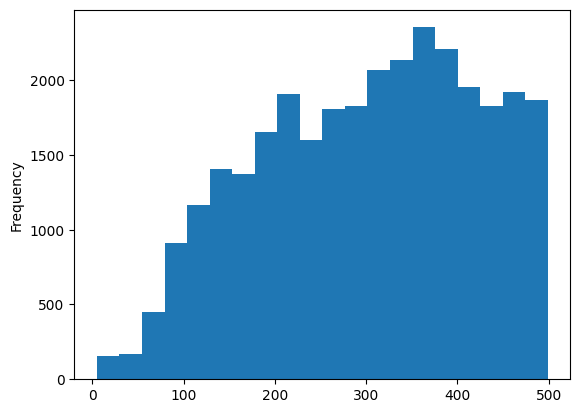

In [29]:
(ann_dataset['seq'].apply(lambda x: len(x.split()) if len(x.split()) < 500 else None)).plot.hist(bins=20)

In [30]:
(ann_dataset['ann'].apply(lambda x: len(x))<5).sum()

0

In [119]:
ann_dataset = ann_dataset.sample(frac=1).reset_index(drop=True)
ann_dataset

,seq,ann,ann_bin_mask
0,M R V A M L T R E Y P P E V Y G G A G V H V T ...,GO:0008150 GO:0008152 GO:0044238 GO:0071704,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, ..."
1,M A D E Q E I M C K L E S I K E I R N K T L Q ...,GO:0008150 GO:0065007 GO:0032501 GO:0008152 GO...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, ..."
2,M P L R L L L L L L W L W G L Q W A E T D S E ...,GO:0008150 GO:0050896 GO:0065007 GO:0009987 GO...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
3,M S P E C A R A A G D A P L R S L E Q A N R T ...,GO:0008150 GO:0050896 GO:0065007 GO:0009987,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
4,M S A D G E F T R T Q I F G T V F E I T N R Y ...,GO:0008150 GO:0000003 GO:0042592 GO:0050896 GO...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...,...
30746,M N V I W R S C I C R L R Q G K V P H R C Q S ...,GO:0008150 GO:0009987 GO:0008152 GO:0032502 GO...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ..."
30747,M S R E L M V E T G G E L I G N T P L L K L N ...,GO:0008150 GO:0009987 GO:0008152 GO:0044238 GO...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ..."
30748,M A P K A K I V L V G S G M I G G V M A T L I ...,GO:0008150 GO:0009987 GO:0008152 GO:0044238 GO...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ..."
30749,M A S K R I L K E L K D L Q K D P P T S C S A ...,GO:0008150 GO:0008152 GO:0044238 GO:0009056 GO...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, ..."


In [120]:
from toy_transformer import *

## Masks

In [121]:
def generate_square_subsequent_mask(sz):
    # mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = (torch.tril(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask
def generate_square_diagnal_mask(sz):
    mask = (torch.diag(torch.ones(sz, device=DEVICE)))
    # mask = 1 - mask
    # mask = torch.zeros([sz, sz], device=DEVICE)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


In [122]:
generate_square_subsequent_mask(5)

tensor([[0., 0., 0., 0., 0.],
        [-inf, 0., 0., 0., 0.],
        [-inf, -inf, 0., 0., 0.],
        [-inf, -inf, -inf, 0., 0.],
        [-inf, -inf, -inf, -inf, 0.]], device='cuda:0')

In [123]:
generate_square_diagnal_mask(5)

tensor([[0., -inf, -inf, -inf, -inf],
        [-inf, 0., -inf, -inf, -inf],
        [-inf, -inf, 0., -inf, -inf],
        [-inf, -inf, -inf, 0., -inf],
        [-inf, -inf, -inf, -inf, 0.]], device='cuda:0')

In [124]:
def create_subsequent_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


def target_mask_fn(tgt):
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)

    return tgt_mask


def target_one_out_mask(tgt):
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_diagnal_mask(tgt_seq_len)

    return tgt_mask


In [125]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List

## Tokenizer

In [126]:
TGT_LANGUAGE = 'ann'
SRC_LANGUAGE = 'seq'

In [127]:
from tokenizers import Tokenizer, models, pre_tokenizers, trainers
from tokenizers.processors import TemplateProcessing

In [128]:
# all_anns = ann_dataset['ann'].apply(lambda x: x.split()).sum()

In [129]:
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]

def get_tokenizer(lang):
    tokenizer = Tokenizer(models.WordLevel(unk_token='[UNK]'))
    tokenizer.pre_tokenizer = pre_tokenizers.WhitespaceSplit()
    
    trainer = trainers.WordLevelTrainer(vocab_size=600, special_tokens=special_tokens, min_frequency=0)
    tokenizer.train_from_iterator(list(ann_dataset[lang])*10, trainer=trainer)
    
    tokenizer.post_processor = TemplateProcessing(
        single=f"[CLS]:0 $A:0 [SEP]:0",
        pair=f"[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
        special_tokens=[
            ("[CLS]", tokenizer.token_to_id('[CLS]')),
            ("[SEP]", tokenizer.token_to_id('[SEP]')),
        ],
    )
    return tokenizer


In [130]:
tokenizers = {lang: get_tokenizer(lang) for lang in (SRC_LANGUAGE, TGT_LANGUAGE)}

In [131]:
tokenizers['ann'].token_to_id('[CLS]')

2

In [132]:
encoding = tokenizers['ann'].encode(ann_dataset.iloc[0].ann)

pd.DataFrame((encoding.tokens, encoding.ids))

,0,1,2,3,4,5
0,[CLS],GO:0008150,GO:0008152,GO:0044238,GO:0071704,[SEP]
1,2,5,8,12,7,3


In [133]:
encoding = tokenizers['seq'].encode(ann_dataset.iloc[0].seq)

pd.DataFrame((encoding.tokens, encoding.ids))

,0,1,2,3,4,5,6,7,8,9,...,379,380,381,382,383,384,385,386,387,388
0,[CLS],M,R,V,A,M,L,T,R,E,...,L,D,I,Y,R,K,V,C,A,[SEP]
1,2,21,12,9,7,21,5,14,12,10,...,5,15,16,20,12,11,9,23,7,3


In [134]:
tokenizers['ann'].get_vocab_size()

119

In [135]:
tokenizers['ann'].get_vocab()

{'GO:0030228': 92,
 'GO:1990298': 107,
 'GO:0034518': 77,
 'GO:1990845': 74,
 'GO:0098772': 23,
 'GO:0016999': 49,
 'GO:0044238': 12,
 'GO:0044423': 63,
 'GO:0140416': 69,
 'GO:1904090': 90,
 'GO:0042592': 27,
 'GO:0042440': 45,
 'GO:0140489': 102,
 'GO:0140299': 68,
 'GO:0030545': 35,
 'GO:0032994': 72,
 'GO:0140223': 73,
 'GO:0033186': 95,
 'GO:0009987': 6,
 'GO:0005575': 16,
 'GO:0022414': 22,
 'GO:0051179': 18,
 'GO:0140657': 47,
 'GO:0002252': 43,
 'GO:0019882': 54,
 'GO:0040011': 37,
 'GO:0019028': 99,
 'GO:0031386': 93,
 'GO:0060089': 32,
 'GO:0005215': 42,
 'GO:0070287': 113,
 'GO:0098561': 96,
 'GO:0140677': 60,
 'GO:0043473': 64,
 'GO:0003824': 30,
 '[MASK]': 4,
 'GO:0051703': 51,
 'GO:0036284': 112,
 'GO:0004873': 98,
 'GO:1990923': 118,
 'GO:0019748': 39,
 'GO:0065007': 9,
 'GO:0016209': 53,
 'GO:0002376': 26,
 'GO:0070085': 44,
 'GO:0000417': 110,
 'GO:0008150': 5,
 'GO:0036338': 85,
 'GO:0032505': 56,
 'GO:1901764': 105,
 'GO:0044281': 36,
 'GO:0005198': 57,
 'GO:0090729'

In [136]:
tokenizers['seq'].get_vocab_size()

25

In [137]:
tokenizers['seq'].encode('A D A').ids

[2, 7, 15, 7, 3]

In [138]:
tokenizers['ann'].decode([10, 13, 22]).split()

['GO:0050896', 'GO:0032502', 'GO:0022414']

In [139]:
def generate_tokens(logits):
    tokens = torch.max(logits, dim=-1)[1]
    return tokens


def decode_tokens(tokens, language: str):
    words = tokenizers[language].decode(tokens.flatten().tolist()).split()
    words = np.array(words).reshape(tokens.shape)
    return words



## Create mask label column

In [140]:
def create_bin_mask(tokenizer, seq):
    n = tokenizer.get_vocab_size()
    # print(n)
    mask = np.zeros([n])
    for id in tokenizer.encode(seq).ids:
        mask[id] = True
    mask[:5] = 0
    return mask
# ann_dataset

create_bin_mask(tokenizers['ann'], ann_dataset.iloc[10]['ann'])

array([0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [141]:
def get_label_array(tokenizer):
    n = tokenizer.get_vocab_size()
    tokens = [''] * n
    for id in range(n):
        # tokens[id] = tokenizer.id_to_token(id)
        tokens[id] = id
    return np.array(tokens)
labels = get_label_array(tokenizers['ann'])
labels

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118])

In [142]:
ann_dataset['ann_bin_mask'] = ann_dataset['ann'].apply(lambda x: create_bin_mask(tokenizers['ann'], x))

In [143]:
NUM_CLASSES = tokenizers['ann'].get_vocab_size()

## Load Term Embeddings

In [144]:
import pandas as pd
df = pd.DataFrame(((k, v.desc) for k, v in ont.items()), columns=('id', 'desc')).set_index('id')
df

,desc
id,
GO:0000001,"""The distribution of mitochondria, including t..."
GO:0000002,"""The maintenance of the structure and integrit..."
GO:0000003,"""The production of new individuals that contai..."
GO:0000006,"""Enables the transfer of zinc ions (Zn2+) from..."
GO:0000007,"""Enables the transfer of a solute or solutes f..."
...,...
GO:2001313,"""The chemical reactions and pathways involving..."
GO:2001314,"""The chemical reactions and pathways resulting..."
GO:2001315,"""The chemical reactions and pathways resulting..."


In [145]:
used_terms = pd.DataFrame([df.loc[k] for k in target_vocab])
used_terms

,desc
GO:0008150,"""A biological process is the execution of a ge..."
GO:0003674,"""A molecular process that can be carried out b..."
GO:0005575,"""A location, relative to cellular compartments..."
GO:0032502,"""A biological process whose specific outcome i..."
GO:0002376,"""Any process involved in the development or fu..."
...,...
GO:0055044,"""The interconnected cell membranes and intrace..."
GO:0042597,"""The region between the inner (cytoplasmic) an..."
GO:0120280,"""The cilary pro-basal body is an immature, par..."
GO:0032126,"""A cell part that is composed of the eisosome ..."


In [146]:
used_terms_embedding = pickle.load(open('states/term_embeddings_used_llm2vec.pickle', 'rb'))
len(used_terms_embedding)

554

In [147]:
used_terms.loc['GO:0140522']

desc    "The activity of joining two lipid bilayers to...
Name: GO:0140522, dtype: object

In [148]:
tokenizers['ann'].get_vocab_size()

119

In [149]:
aligned_embedding = np.zeros([tokenizers['ann'].get_vocab_size(), used_terms_embedding.shape[1]])

for term, embedding in zip(used_terms.index, used_terms_embedding):
    token_id = tokenizers['ann'].token_to_id(term)
    if not token_id:
        continue
    aligned_embedding[token_id, :] = embedding



In [150]:
aligned_embedding

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.88671875, -0.484375  , -0.93359375, ...,  1.3046875 ,
        -2.390625  ,  0.98046875],
       [ 2.96875   , -0.640625  , -3.3125    , ...,  0.12988281,
        -3.015625  ,  0.28515625],
       [ 0.07519531, -1.0078125 , -2.25      , ..., -0.51171875,
        -5.1875    , -0.59765625]])

In [151]:
for sp_token in special_tokens:
    print(sp_token)
    token_id = tokenizers['ann'].token_to_id(sp_token)
    print(token_id)
    aligned_embedding[token_id, :] = np.random.uniform(-1, 1, aligned_embedding.shape[1])
    
aligned_embedding

[UNK]
0
[PAD]
1
[CLS]
2
[SEP]
3
[MASK]
4


array([[ 0.57480561,  0.61550922,  0.95322824, ...,  0.62343942,
         0.46579016, -0.91195442],
       [-0.51774537,  0.6799343 , -0.81867311, ...,  0.07029006,
         0.6613273 ,  0.72469739],
       [ 0.66010857,  0.59188574, -0.41768656, ..., -0.6155993 ,
         0.2661952 , -0.86901092],
       ...,
       [ 0.88671875, -0.484375  , -0.93359375, ...,  1.3046875 ,
        -2.390625  ,  0.98046875],
       [ 2.96875   , -0.640625  , -3.3125    , ...,  0.12988281,
        -3.015625  ,  0.28515625],
       [ 0.07519531, -1.0078125 , -2.25      , ..., -0.51171875,
        -5.1875    , -0.59765625]])

In [152]:
PAD_IDX = tokenizers['ann'].token_to_id('[PAD]')
PAD_IDX

1

## Transformations

In [153]:

# base_vocab_size = len(vocab)
src_vocab_size = tokenizers[SRC_LANGUAGE].get_vocab_size()
target_vocab_size = tokenizers[TGT_LANGUAGE].get_vocab_size()
# src_vocab_size = base_vocab_size + len(special_symbols)
# target_vocab_size = base_vocab_size + len(special_symbols)
# num_layers = 10
seq_length = MAX_LEN + 2
seq_length

22

In [154]:
# def collate_fn(batch):
#     src_batch, tgt_batch = [], []
#     for src_sample, tgt_sample in batch:
#         src_batch.append(torch.tensor(tokenizers[SRC_LANGUAGE].encode(src_sample).ids))
#         tgt_batch.append(torch.tensor(tokenizers[TGT_LANGUAGE].encode(tgt_sample).ids))

#     # pad_first_to_len(src_batch, seq_length)
#     # pad_first_to_len(tgt_batch, seq_length)
    
#     src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
#     tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
#     return src_batch, tgt_batch

## Data splits

In [155]:
def AnnData(split='train'):
    n = len(ann_dataset)
    n_train = int(n * 8 / 10)
    n_valid = int(n / 10)
    if split == 'train':
        return ann_dataset.to_numpy()[:n_train]
    elif split == 'valid':
        return ann_dataset.to_numpy()[n_train:n_train+n_valid]
    else:
        return ann_dataset.to_numpy()[n_train+n_valid:]

## Train and eval functions

In [156]:
BATCH_SIZE = 20


In [157]:
def evaluate(model):
    model.eval()
    losses = 0

    # val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_iter = AnnData(split='valid')
    # val_iter = ann_dataset
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    hit_rates = []
    num_batches = 10
    i = 0
    for src, tgt, masks in val_dataloader:
        # print(i)
        src = src.T.to(DEVICE)
        masks = masks.T.to(DEVICE)

        logits = model(src)
        # tokens = generate_tokens(logits)

        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), masks.reshape(-1))
        # loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt.reshape(-1))
        losses += loss.item()

        if i >= num_batches:
            break
        i += 1

        hit_rate = ((tgt_out == tokens).sum() / count_words(tgt_out)).cpu().numpy()[()]

        print('label', tgt_out)
        print('pred', tokens)
        print(hit_rate)
        hit_rates.append(hit_rate)

    return {'loss': losses / len(list(val_dataloader)), 'hit_rate': np.mean(hit_rates)}

In [158]:
def count_words(x):
    return (x != PAD_IDX).sum()

In [159]:
from collections import deque

In [160]:
class MA:
    def __init__(self, n):
        self.n = n
        self.data = deque()
        self.s = 0
        self.l = 0

    def __call__(self, x):
        if np.isnan(x):
            return self.s / self.l if self.l else np.nan
        self.data.append(x)
        self.s += x
        self.l += 1
        if self.l > self.n:
            self.s -= self.data.popleft()
            self.l -= 1

        return self.s / self.l
            
        

In [161]:
ma = MA(10)

In [162]:
ma(1)

1.0

In [163]:
ma = MA(10)

In [164]:
ma(np.nan)

nan

In [165]:
ma.__dict__

{'n': 10, 'data': deque([]), 's': 0, 'l': 0}

In [166]:
from matplotlib.artist import Artist

class CurveAnimation:
    def __init__(self, window_size=500):
        self.curve_x = []
        self.curve_y = []
        self.ma = MA(window_size)
        self.curve_ma = []
        self.window_size = window_size
        self.fig, self.ax = plt.subplots()
        self.line, = self.ax.plot([], [])
        self.line_ma, = self.ax.plot([], [])
        self.text = self.ax.text(0.85, 0.90, '', color=self.line.get_color(), transform=self.ax.transAxes)
        self.text_ma = self.ax.text(0.85, 0.95, '', color=self.line_ma.get_color(), transform=self.ax.transAxes)
        self.ty = 0.02
        def new_text():
            t = self.ax.text(0.02, self.ty, '', transform=self.ax.transAxes)
            self.ty += 0.05
            return t
        self.texts = defaultdict(new_text)
        display(self.fig)

    def add_data(self, new_data, texts=None):
        self.curve_y.append(new_data)
        self.curve_x.append(len(self.curve_x))
        self.curve_ma.append(self.ma(new_data))
        self.plot(texts)

    def plot(self, texts=None):
        self.line.set_data(self.curve_x[-self.window_size:], self.curve_y[-self.window_size:])
        self.line_ma.set_data(self.curve_x[-self.window_size:], self.curve_ma[-self.window_size:])
        self.text.set_text(f'curr={self.curve_y[-1]:.3f}')
        self.text_ma.set_text(f'ma={self.curve_ma[-1]:.3f}')

        if texts:
            for k, t in texts.items():
                self.texts[k].set_text(f'{k}: {t}')
        
        self.ax.relim()
        self.ax.autoscale_view(True,True,True)
        clear_output(wait=True)
        display(self.fig)





## Train functions

In [167]:
BATCH_SIZE = 20

In [168]:
BATCH_SIZE

20

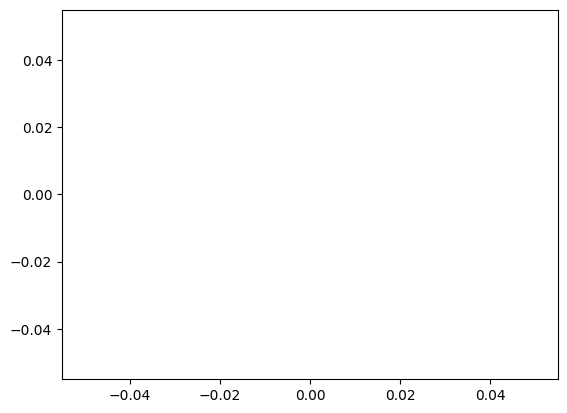

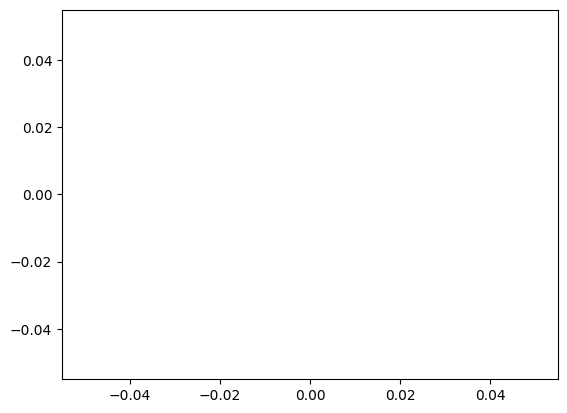

In [169]:
import traceback as tb

anm = CurveAnimation()

In [170]:
ITER_REPEATS = 100

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    # train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_iter = AnnData(split='train')
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, masks in train_dataloader:
        # print(i)
        src = src.T.to(DEVICE)
        masks = masks.T.to(DEVICE)

        def step(i):
            nonlocal losses
            try:
                logits = model(src)
                # tokens = generate_tokens(logits)
            except Exception as e:
                tb.print_exc()
                # print(src.shape, tgt.shape)
                raise e

            # print(logits.shape, masks.shape)
            
            optimizer.zero_grad()

            # print(logits.dtype, masks.dtype)
            # loss = loss_fn(logits.reshape(-1, logits.shape[-1]), masks.reshape(-1))
            loss = loss_fn(logits, masks)
            
            loss.backward()
    
            optimizer.step()
            losses += loss.item()

            pred_mask = logits.detach().cpu().numpy() > 0.5
            tokens = []
            for flags in pred_mask:
                tokens.append(labels[flags])
            # print(tokens)

            label_masks = masks.cpu().numpy().astype(bool)
            tgt_out = []
            for tgt in label_masks:
                tgt_out.append(labels[tgt])
            
            def tolist(x):
                return x.tolist() # [:10]
            def get_token_logits(logits, tokens):
                r = []
                for li, t in zip(logits, tokens):
                    r.append(f'{li[t]:.2f}')
                return r
            i = 0
            # anm.add_data(loss.item(), texts={
            #     'label': f'{tolist(tgt_out[i])}',
            #     'pred': f'{tolist(tokens[i])}',
            #     # 'logits': f'{get_token_logits(logits[i], tokens[i])}',
            # })
            recall = (pred_mask & label_masks).sum() / label_masks.sum()
            precision = (pred_mask & label_masks).sum() / pred_mask.sum()
            f1 = recall * precision / (recall + precision)
            anm.add_data(f1, texts={
                'label': f'{tolist(tgt_out[i])}',
                'pred': f'{tolist(tokens[i])}'
            })
        
        for i in range(ITER_REPEATS):
            step(i)

    # return losses / len(list(train_dataloader))
    return anm.curve_ma[-1]

In [171]:
try:
    train_loss = train_epoch(transformer, optimizer)
except:
    pass

In [172]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [173]:
# model = Transformer(embed_dim=128, src_vocab_size=src_vocab_size,
#                     target_vocab_size=target_vocab_size, seq_length=30,
#                     num_layers=16, expansion_factor=4, n_heads=16,
#                     target_mask_fn=target_one_out_mask)

# transformer = model
# for p in transformer.parameters():
#     if p.dim() > 1:
#         nn.init.xavier_uniform_(p)

# transformer = transformer.to(DEVICE)


## Load ProtBERT

In [174]:
# USE_ProtBERT = False
USE_ProtBERT = True

In [175]:
from torch import nn

In [176]:
from transformers import BertConfig, BertModel, BertTokenizer
protbert_tokenizer = BertTokenizer.from_pretrained('Rostlab/prot_bert')
protbert_config = BertConfig.from_pretrained('Rostlab/prot_bert')
# protbert_config = BertConfig.from_pretrained('states/protbert_pruned/')
protbert_config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 40000,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 30,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30
}

In [177]:
tokenizers[SRC_LANGUAGE] = protbert_tokenizer

In [178]:
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample, masks in batch:
        src_batch.append(tokenizers[SRC_LANGUAGE](src_sample, return_tensors='pt')['input_ids'][0])
        # tgt_batch.append(torch.tensor(tokenizers[TGT_LANGUAGE].encode(tgt_sample).ids))
        tgt_batch.append(torch.tensor(masks, dtype=torch.float))

    # pad_first_to_len(src_batch, seq_length)
    # pad_first_to_len(tgt_batch, seq_length)
    
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [179]:
import textpruner
from transformers import XLMRobertaForSequenceClassification,XLMRobertaTokenizer

from textpruner import summary, TransformerPruner
import sys


# if not loaded_from_pickle and USE_ProtBERT:
#     # protbert_model.protbert_model.load_state_dict(torch.load("states/prot_bert_weights.pth"))
#     protbert_model.protbert_model = pickle.load(open('states/prot_bert_pruned_25.pickle', 'rb'))
#     # protbert_model.protbert_model.load_state_dict(torch.load("states/prot_bert_weights_pruned_25.pth"))
#     # protbert_model.prune()
#     transformer.encoder = protbert_model


## Model

In [180]:
MAX_LEN = 20

In [181]:
states_dir = 'states/seq_classification'

In [182]:
continue_previous = True
pickle_file = f'{states_dir}/seq_classification_pruned_protbert.pickle'
# continue_previous = False

In [183]:
#!pip install -U nn_pruning

In [184]:
class ProtBERT_Adapter(nn.Module):
    def __init__(self, config, embed_dim=1024):
        super(ProtBERT_Adapter, self).__init__()
        self.protbert_model = BertModel(config)
        assert(embed_dim <= 1024)
        self.embed_dim = embed_dim
        self.embed_idx = np.sort(np.random.choice(np.arange(1024), embed_dim, replace=False))
        print(self.embed_idx)

    def prune(self, p=0.25):
        print("Before pruning:")
        print(summary(self.protbert_model))
        
        pruner = TransformerPruner(self.protbert_model)
        
        ffn_mask = textpruner.pruners.utils.random_mask_tensor((16,4096), p=p)
        head_mask = textpruner.pruners.utils.random_mask_tensor((30,16), p=p, even_masks=False)
        
        print(ffn_mask, head_mask)
        
        pruner.prune(head_mask=head_mask, ffn_mask=ffn_mask,save_model=True)
        
        print("After pruning:")
        print(summary(self.protbert_model))

    def forward(self, input_ids, attention_mask=None):
        outputs = self.protbert_model(input_ids=input_ids, attention_mask=attention_mask)
        embedding = outputs.last_hidden_state

        return embedding[:, 0, self.embed_idx]

    def hidden_states(self, input_ids, attention_mask=None):
        outputs = self.protbert_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        return {'': outputs.last_hidden_state[:, self.embed_idx]}


In [185]:
class StaticEncoder(nn.Module):
    pass

In [186]:

EMBED_DIM = 1024

In [187]:
def sample_embed(embedding):
    sigma = embedding.std(0)
    rand_idx = np.random.choice(np.arange(embedding.shape[1]), EMBED_DIM, replace=False, p=sigma/sigma.sum())
    # print(sigma[rand_idx].shape)
    return embedding[:, rand_idx]
    
sampled_embedding = sample_embed(aligned_embedding)

In [188]:
class NNLayer(nn.Module):
    def __init__(self, ninput, noutput):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(ninput, noutput),
            nn.ReLU(),
            # nn.Linear(noutput, noutput),
            # nn.Sigmoid(),
        )
        # assert noutput % ninput == 0
        # k = (ninput + noutput - 1) // noutput
        # self.pool = nn.MaxPool1d(k)
        # self.padding = nn.ZeroPad1d(n
        self.norm = nn.LayerNorm(noutput)

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        
        return self.norm(out)

class GOClassModel(nn.Module):
    def __init__(self, encoder, layers):
        super().__init__()
        self.encoder = encoder
        self.layers = nn.ModuleList([
            NNLayer(layers[i], layers[i+1]) for i in range(len(layers) - 1)
        ])
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        enc = self.encoder(x)
        out = enc
        for layer in self.layers:
            out = layer(out)
        out = self.sigmoid(out)
        return out



In [189]:
from toy_transformer import Transformer

# loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
loss_fn = torch.nn.functional.binary_cross_entropy


loaded_from_pickle = False
if continue_previous and os.path.exists(pickle_file):
    print('Loading model')
    transformer = pickle.load(open(pickle_file, 'rb'))
    loaded_from_pickle = True
else:
    print('Creating new model')
    protbert = ProtBERT_Adapter(protbert_config, EMBED_DIM)
    protbert.prune()
    # model = GOClassModel(protbert, [1024, 2048, 1024, 512, 256, NUM_CLASSES])
    # model = GOClassModel(protbert, [1024, 512, 256, NUM_CLASSES])
    model = GOClassModel(protbert, [1024, NUM_CLASSES])
    # model = Transformer(embed_dim=EMBED_DIM, src_vocab_size=src_vocab_size,
    #                     target_vocab_size=target_vocab_size, source_seq_length=510+2, target_seq_length=MAX_LEN+2,
    #                     num_layers=5, expansion_factor=1, n_heads=32,
    #                     target_mask_fn=target_mask_fn,
    #                     target_embedding=torch.tensor(sampled_embedding, dtype=torch.float)
    #                    )


    transformer = model
    
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    
    transformer = transformer.to(DEVICE)

Creating new model
[   0    1    2 ... 1021 1022 1023]
Before pruning:

LAYER NAME                  	        #PARAMS	     RATIO	 MEM(MB)
--model:                    	    419,931,136	   100.00%	 1601.91
  --embeddings:             	     40,994,816	     9.76%	  156.38
    --word_embeddings:      	         30,720	     0.01%	    0.12
    --position_embeddings:  	     40,960,000	     9.75%	  156.25
    --token_type_embeddings:	          2,048	     0.00%	    0.01
    --LayerNorm:            	          2,048	     0.00%	    0.01
  --encoder                 
    --layer:                	    377,886,720	    89.99%	 1441.52
  --pooler                  
    --dense:                	      1,049,600	     0.25%	    4.00

tensor([[0., 1., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]) tensor([[1., 1., 1., 0., 0., 1

In [190]:
param_name = "protbert_model.encoder.layer.0.attention.self.query.weight"
initial_param = transformer.encoder.state_dict()[param_name].clone()

# Print initial parameter values
print(f"Initial parameter values for {param_name}:\n", initial_param)


Initial parameter values for protbert_model.encoder.layer.0.attention.self.query.weight:
 tensor([[ 0.0400, -0.0400,  0.0011,  ..., -0.0144,  0.0498,  0.0461],
        [ 0.0466,  0.0256,  0.0256,  ...,  0.0214,  0.0138, -0.0550],
        [-0.0178,  0.0062,  0.0343,  ..., -0.0194,  0.0272, -0.0509],
        ...,
        [ 0.0390,  0.0019,  0.0369,  ..., -0.0434,  0.0279,  0.0152],
        [ 0.0027,  0.0118, -0.0230,  ...,  0.0425,  0.0033, -0.0512],
        [ 0.0331, -0.0325,  0.0454,  ...,  0.0229,  0.0392,  0.0209]],
       device='cuda:0')


updated_param = transformer.encoder.state_dict()[param_name]
print(f"Updated parameter values for {param_name}:\n", updated_param)


In [191]:

transformer = transformer.to(DEVICE)

In [192]:
sample_data = ann_dataset.sample(1)
sample_data

,seq,ann,ann_bin_mask
15049,M H L L C F L S L A C S L L A A A L I P S P R ...,GO:0008150 GO:0050896 GO:0065007 GO:0009987 GO...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."


In [193]:
sample_inputs = tokenizers[SRC_LANGUAGE](sample_data.iloc[0][SRC_LANGUAGE], return_tensors='pt')['input_ids'].to(DEVICE)
sample_inputs

tensor([[ 2, 21, 22,  5,  5, 23, 19,  5, 10,  5,  6, 23, 10,  5,  5,  6,  6,  6,
          5, 11, 16, 10, 16, 13,  9,  6, 16,  6, 15,  8,  6,  6, 19,  9, 10,  7,
          5,  7, 19, 10,  9,  6,  9, 16, 14,  7,  7,  9,  8, 12,  6, 19,  9,  7,
         12, 14,  5,  9,  9, 18,  5, 13, 10,  8, 10, 10,  8, 14,  9,  5, 21, 10,
          8,  5, 20, 16, 14, 20, 24, 12, 21, 20, 12, 23, 18,  5, 13, 12,  7,  7,
         24, 18, 18, 16, 15,  5, 17, 15, 13, 15,  7, 14, 10,  8, 12, 19,  6,  6,
          6, 22, 20, 17, 15,  9, 11,  5, 12, 10, 11, 14, 17,  9, 24, 13, 12, 15,
         18, 23, 21, 16, 13,  9,  8, 23, 11, 14,  8,  7, 12,  9, 19,  7,  6,  6,
         15, 17, 15, 19, 19, 12, 16, 16, 23,  8, 10,  8, 20, 13, 23,  7,  7, 23,
         23, 17, 10,  9,  7,  5, 18, 23, 21, 17, 15, 10, 15,  7, 20,  5, 10, 12,
         15,  5, 19,  9, 11, 15,  8, 16,  5, 10, 18,  7, 16, 12, 16,  8, 15, 11,
         10, 19,  6, 17, 22, 15, 10, 23, 13, 23, 21, 10, 12,  5, 14,  8, 20, 13,
         18,  8, 22, 10, 11,

In [194]:
sample_outputs = transformer(sample_inputs)
sample_outputs

tensor([[0.3379, 0.7694, 0.6648, 0.3379, 0.9820, 0.3379, 0.3379, 0.3379, 0.7118,
         0.3379, 0.3379, 0.3379, 0.3833, 0.8225, 0.3436, 0.3379, 0.3379, 0.3755,
         0.6811, 0.3379, 0.3379, 0.4407, 0.4385, 0.3379, 0.6600, 0.3379, 0.8241,
         0.6327, 0.9715, 0.4376, 0.7402, 0.3379, 0.3379, 0.3379, 0.3379, 0.8310,
         0.3379, 0.5611, 0.9384, 0.3379, 0.3379, 0.3379, 0.3379, 0.3379, 0.5452,
         0.3379, 0.5216, 0.3379, 0.3379, 0.6714, 0.3379, 0.4234, 0.3379, 0.3379,
         0.8049, 0.3379, 0.3932, 0.9551, 0.3379, 0.3379, 0.8084, 0.3379, 0.3379,
         0.3379, 0.3379, 0.3379, 0.5454, 0.6437, 0.3379, 0.3716, 0.3379, 0.6338,
         0.3379, 0.3718, 0.5765, 0.5262, 0.6220, 0.3379, 0.5894, 0.7315, 0.7543,
         0.3379, 0.7464, 0.3379, 0.8421, 0.6306, 0.4026, 0.8395, 0.3379, 0.3379,
         0.4085, 0.6810, 0.3379, 0.4501, 0.4083, 0.8386, 0.7477, 0.3379, 0.4792,
         0.3379, 0.3379, 0.3379, 0.3606, 0.3379, 0.3379, 0.3379, 0.3465, 0.3379,
         0.9249, 0.8662, 0.6

In [195]:
sample_target = torch.tensor([tokenizers[TGT_LANGUAGE].encode(sample_data.iloc[0][TGT_LANGUAGE]).ids]).to(DEVICE)
sample_target

tensor([[ 2,  5, 10,  9,  6, 15,  3]], device='cuda:0')

In [196]:
# outputs = transformer.hidden_states(sample_inputs, sample_target)
# outputs.keys()

In [197]:
print(str(transformer).replace('  ', '|   '))

GOClassModel(
|   (encoder): ProtBERT_Adapter(
|   |   (protbert_model): BertModel(
|   |   |   (embeddings): BertEmbeddings(
|   |   |   |   (word_embeddings): Embedding(30, 1024, padding_idx=0)
|   |   |   |   (position_embeddings): Embedding(40000, 1024)
|   |   |   |   (token_type_embeddings): Embedding(2, 1024)
|   |   |   |   (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
|   |   |   |   (dropout): Dropout(p=0.0, inplace=False)
|   |   |   )
|   |   |   (encoder): BertEncoder(
|   |   |   |   (layer): ModuleList(
|   |   |   |   |   (0): BertLayer(
|   |   |   |   |   |   (attention): BertAttention(
|   |   |   |   |   |   |   (self): BertSelfAttention(
|   |   |   |   |   |   |   |   (query): Linear(in_features=1024, out_features=576, bias=True)
|   |   |   |   |   |   |   |   (key): Linear(in_features=1024, out_features=576, bias=True)
|   |   |   |   |   |   |   |   (value): Linear(in_features=1024, out_features=576, bias=True)
|   |   |   |   |   |   |   

In [198]:
x = {}
y = x[2] = 3
y

3

In [199]:
def substitute_encoder(model, encoder):
    model.encoder = encoder
    # need to make sure the embedding dimensions are the same

## Check Mem usage

In [200]:
# from torch.profiler import profile, record_function, ProfilerActivity

# # Use profiler to track memory usage
# with profile(activities=[ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
#     with record_function("model_inference"):
#         for i in range(10):
#         # i = 2
#             inputs = tokenizers['seq'](ann_dataset.iloc[i]['seq'], return_tensors='pt')['input_ids'].to(DEVICE)
#             target = torch.tensor([tokenizers['ann'].encode(ann_dataset.iloc[i]['ann']).ids]).to(DEVICE)
#             outputs = transformer(inputs, target)

# # Print profiling results
# print(prof.key_averages().table(sort_by="cuda_memory_usage", row_limit=10))

In [201]:
# len(ann_dataset.iloc[i]['seq'])

In [202]:
# protbert_model.protbert_model(**protbert_tokenizer(ann_dataset.iloc[2]['seq'], return_tensors='pt').to(DEVICE))

## Training

In [203]:
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.000005, betas=(0.98, 0.999), eps=1e-9)

In [204]:
BATCH_SIZE = 5
ITER_REPEATS = 1

In [205]:

# for p in transformer.parameters():
#     if p.dim() > 1:
#         nn.init.xavier_uniform_(p)


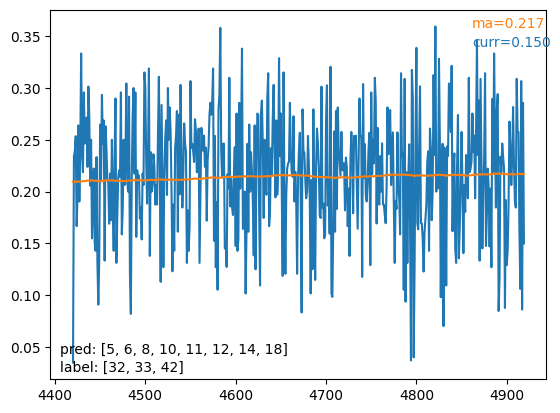

ValueError: not enough values to unpack (expected 3, got 2)

In [206]:
NUM_EPOCHS = 1

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    eval_res = evaluate(transformer)
    val_loss = eval_res['loss']
    val_hit  = eval_res['hit_rate']
    # if epoch % 10 == 0:

print(( f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
pickle.dump(transformer, open(pickle_file, 'wb'))

In [ ]:
os.mkdir('states/seq_classification')

In [ ]:
pickle.dump(transformer, open(pickle_file, 'wb'))

In [ ]:
x = np.ones(2)
x.astype(bool)

In [ ]:
torch.nn.rei
transformer.

## Debugging

In [ ]:
sample_data = ann_dataset.sample(1)
sample_data

In [ ]:
sample_inputs = tokenizers[SRC_LANGUAGE](sample_data.iloc[0][SRC_LANGUAGE], return_tensors='pt')['input_ids'].to(DEVICE)
sample_inputs

In [ ]:
sample_target = torch.tensor([tokenizers[TGT_LANGUAGE].encode(sample_data.iloc[0][TGT_LANGUAGE]).ids]).to(DEVICE)
sample_target

In [ ]:
outputs = transformer(sample_inputs, sample_target)
outputs

In [ ]:
hidden_states = transformer.hidden_states(sample_inputs, sample_target)

In [ ]:
hidden_states.keys()

In [ ]:
list(transformer.decoder.fc_out.named_parameters())[0][1]

In [ ]:
hidden_states['decoder.fc_out'][0, 1, :]

In [ ]:
for k, v in hidden_states.items():
    print(k, v.shape)

In [ ]:
transformer.decoder.embedding_layer(sample_target[0, 3:4])

In [ ]:
list(transformer.decoder.embedding_layer)

## Evaluate

In [ ]:
evaluate(transformer)

In [ ]:
plt.plot(anm.curve_y)

In [ ]:
pickle.dump(transformer, open(pickle_file, 'wb'))

In [ ]:
pickle_file

In [ ]:
torch.cuda.empty_cache()